In [1]:
from omegaconf import OmegaConf
import numpy as np
import os
import re
import os.path as osp
import torch
import pytorch_lightning as pl
from tqdm import tqdm
from omegaconf import OmegaConf
import wandb
from pytorch_lightning.loggers import WandbLogger

import model_factory
from graph_data_module import GraphDataModule
from train import Runner
from datasets.dataset_factory import create_dataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchmetrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
entity = "haraghi"
project = "DGCNN"

In [43]:
run_ids = ['32r0ngy0','kt655slc']

artifact_dirs = [WandbLogger.download_artifact(artifact=f"haraghi/DGCNN/model-{run_id}:best") for run_id in run_ids]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [44]:
api = wandb.Api()

In [45]:
configs = [api.run(osp.join(entity, project, run_id)).config for run_id in run_ids]
cfgs = [OmegaConf.create(config) for config in configs]
cfg_files = []
for cfg in cfgs:
    if "cfg_path" in cfg.keys():
        cfg_files.append(OmegaConf.load(cfg.cfg_path))
    else:
        cfg_files.append(cfg)
            
    
# cfg = OmegaConf.merge(cfg_file, cfg)
# print(OmegaConf.to_yaml(cfg))

In [12]:
# run = wandb.init()
# checkpoint_reference = osp.join(entity, project, "model-" + run_id+":best")
# artifact = run.use_artifact(checkpoint_reference, type='model')
# artifact_dir = artifact.download()

In [46]:
def recursive_dict_compare(all_cfg, other_cfg):
    """
    Recursively compare two dictionaries and return their differences.
    """

    
    # Initialize the result dictionary
    diff = {}

    # Check for keys in dict1 that are not in dict2
    for key in other_cfg:
        if key not in all_cfg:
            diff[key] = other_cfg[key]
        else:
            # If the values are dictionaries, recursively compare them
            if isinstance(all_cfg[key], dict) and isinstance(other_cfg[key], dict):
                nested_diff = recursive_dict_compare(all_cfg[key], other_cfg[key])
                if nested_diff:
                    diff[key] = nested_diff
            # Otherwise, compare the values directly
            elif all_cfg[key] != other_cfg[key]:
                if not(key == "num_classes" and other_cfg[key] is None and all_cfg[key] is not None):
                    diff[key] = other_cfg[key]
                    

    return diff


In [50]:

print([recursive_dict_compare(OmegaConf.to_object(cfg),OmegaConf.to_object(cfg_file)) for cfg, cfg_file in zip(cfgs, cfg_files)])

[{}, {'train': {'epochs': 500, 'profiler': 'simple'}, 'wandb': {'experiment_name': 'DGCNN no aug. (no subsampling)'}}]


In [51]:
def percentile(t, q):
    B, C, H, W = t.shape
    k = 1 + round(.01 * float(q) * (C * H * W - 1))
    result = t.view(B, -1).kthvalue(k).values
    return result[:,None,None,None]

def create_image(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()

    representation = torchvision.utils.make_grid(representation)

    return representation

In [64]:
if False:
    print("yes")

In [61]:
# Seed everything. Note that this does not make training entirely
# deterministic.
for cfg in cfgs:
    pl.seed_everything(cfg.seed, workers=True)

for cfg in cfgs[1:]:
    compare_dict = recursive_dict_compare(OmegaConf.to_object(cfgs[0].dataset),OmegaConf.to_object(cfg.dataset))
    if len(compare_dict)!=0:
        if not (len(compare_dict) == 1 and 'num_workers' in compare_dict.keys()):
            print(compare_dict)
            print(cfg.dataset)
            print(cfgs[0].dataset)
            # raise Exception("Datasets are not the same")
# Create datasets using factory pattern
gdm = GraphDataModule(cfgs[0])
for cfg in cfgs:
    cfg.dataset.num_classes = gdm.num_classes

Global seed set to 0
Global seed set to 0


{'num_classes': 2, 'num_workers': 8, 'image_resolution': None}
{'name': 'NCARS', 'num_classes': 2, 'num_workers': 8, 'dataset_path': None, 'image_resolution': None, 'train_percentage': 0.75, 'num_samples_per_class': None, 'validation_percentage': 0.1}
{'name': 'NCARS', 'num_classes': None, 'num_workers': 4, 'dataset_path': None, 'train_percentage': 0.75, 'num_samples_per_class': None, 'validation_percentage': 0.1}


ConfigAttributeError: Missing key shift_and_flip
    full_key: transform.train.shift_and_flip
    object_type=dict

In [ ]:
# test_file_list = []
# for data in gdm.test_dataloader():
#     test_file_list.extend(data.file_id)

In [ ]:
# train_file_list = []
# for data in gdm.train_dataloader():
#     train_file_list.extend(data.file_id)

In [ ]:
# val_file_list = []
# for data in gdm.val_dataloader():
#     val_file_list.extend(data.file_id)

In [ ]:
# print(len(train_file_list))
# print(len(test_file_list))
# print(len(val_file_list))

In [ ]:
# print(set(test_file_list).intersection(set(val_file_list)))
# print(set(test_file_list).intersection(set(train_file_list)))
# print(set(val_file_list).intersection(set(train_file_list)))

In [21]:
model = models[2]
saved_param = saved_params[2]

In [22]:
for mm,nn in model.named_parameters():
    print(mm)
    

conv1.nn.lins.0.weight
conv1.nn.lins.0.bias
conv1.nn.lins.1.weight
conv1.nn.lins.1.bias
conv1.nn.lins.2.weight
conv1.nn.lins.2.bias
conv1.nn.norms.0.module.weight
conv1.nn.norms.0.module.bias
conv1.nn.norms.1.module.weight
conv1.nn.norms.1.module.bias
conv2.nn.lins.0.weight
conv2.nn.lins.0.bias
lin1.weight
lin1.bias
mlp.lins.0.weight
mlp.lins.0.bias
mlp.lins.1.weight
mlp.lins.1.bias
mlp.lins.2.weight
mlp.lins.2.bias


In [20]:
for kk in saved_param['state_dict'].keys():
    print(kk)


model.conv1.nn.lins.0.weight
model.conv1.nn.lins.0.bias
model.conv1.nn.lins.1.weight
model.conv1.nn.lins.1.bias
model.conv1.nn.lins.2.weight
model.conv1.nn.lins.2.bias
model.conv1.nn.norms.0.weight
model.conv1.nn.norms.0.bias
model.conv1.nn.norms.0.running_mean
model.conv1.nn.norms.0.running_var
model.conv1.nn.norms.0.num_batches_tracked
model.conv1.nn.norms.1.weight
model.conv1.nn.norms.1.bias
model.conv1.nn.norms.1.running_mean
model.conv1.nn.norms.1.running_var
model.conv1.nn.norms.1.num_batches_tracked
model.conv2.nn.lins.0.weight
model.conv2.nn.lins.0.bias
model.lin1.weight
model.lin1.bias
model.mlp.lins.0.weight
model.mlp.lins.0.bias
model.mlp.lins.1.weight
model.mlp.lins.1.bias
model.mlp.lins.2.weight
model.mlp.lins.2.bias


In [16]:
saved_params = []
for artifact_dir, cfg, model in zip(artifact_dirs, cfgs, models):
    print(artifact_dir)
    saved_params.append(torch.load(osp.join(artifact_dir,"model.ckpt")))

./artifacts/model-di9222jw:v15
./artifacts/model-cfvaexbi:v12
./artifacts/model-32r0ngy0:v499


In [14]:

models = [model_factory.factory(cfg) for cfg in cfgs]

# Tie it all together with PyTorch Lightning: Runner contains the model,
# optimizer, loss function and metrics; Trainer executes the
# training/validation loops and model checkpointing.
 
runners = [Runner.load_from_checkpoint(osp.join(artifact_dir,"model.ckpt"), cfg=cfg, model=model) for artifact_dir, cfg, model in zip(artifact_dirs, cfgs, models)]

Lightning automatically upgraded your loaded checkpoint from v1.5.0 to v2.0.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file artifacts/model-32r0ngy0:v499/model.ckpt`


ConfigAttributeError: Missing key loss_fn
    full_key: train.loss_fn
    object_type=dict

In [68]:
trainer = pl.Trainer(
    enable_progress_bar=True,
    # Use DDP training by default, even for CPU training
    # strategy="ddp_notebook",
    devices=torch.cuda.device_count(),
    accelerator="auto"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [70]:
for runner in runners:
    print(runner.cfg.model)
    trainer.test(runner, datamodule=gdm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'k': None, 'aggr': '', 'name': 'EST', 'cnn_type': 'mobilenet_v3_small', 'num_bins': 9, 'est_activation': 'nn.LeakyReLU(negative_slope=0.1)', 'est_mlp_layers': [1, 30, 30, 1], 'resnet_pretrained': False, 'resnet_crop_dimension': [224, 224]}
Testing DataLoader 0: 100%|██████████| 87/87 [00:10<00:00,  8.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.7698385119438171
        test/loss           1.5518068075180054
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'k': None, 'aggr': '', 'name': 'EST', 'num_bins': 9, 'est_activation': 'nn.LeakyReLU(negative_slope=0.1)', 'est_mlp_layers': [1, 30, 30, 1], 'resnet_pretrained': True, 'resnet_crop_dimension': [224, 224]}
Testing DataLoader 0: 100%|██████████| 87/87 [00:22<00:00,  3.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9308702349662781
        test/loss           0.3228365480899811
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [71]:
dl = DataLoader(
            create_dataset(
                dataset_path = gdm.dataset_path,
                dataset_name  = gdm.dataset_name,
                dataset_type = 'test',
                transform = gdm.transform_dict['test'],
                num_workers=gdm.num_workers
            ),
            batch_size=16,
            shuffle=False,
            num_workers=gdm.num_workers,
        )
ds = create_dataset(
        dataset_path = gdm.dataset_path,
        dataset_name  = gdm.dataset_name,
        dataset_type = 'test',
        transform = gdm.transform_dict['test'],
        num_workers=gdm.num_workers
    )

In [72]:
def compute_confusion_matrix(runner,gdm):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = runner.model.to(device)
    model.eval()

    correct = 0
    total = 0

    y=torch.tensor([],device=device)
    y_hat=torch.tensor([],device=device)
    preds = []
    targets = []
    files = []
    with torch.no_grad():
        for data in tqdm(gdm.test_dataloader()):
            files.extend(data.file_id)
            targets.append(data.y)
            data = data.to(device)
            y = torch.cat((y,data.y))
            out = model(data)
            preds.append(out.clone().detach().cpu())
            label = torch.argmax(out, dim=1) 
            y_hat = torch.cat((y_hat,label))
            correct += torch.sum(label == data.y)
            total += data.y.shape[0]
    print(correct/total)   
    y = y.clone().detach().cpu().numpy()
    y_hat = y_hat.clone().detach().cpu().numpy() 
    preds_ = torch.cat(preds,dim=0) #.permute(0,2,1)
    targets_ = torch.cat(targets,dim=0)
    metrics = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=runner.cfg.dataset.num_classes) 
    metrics.update(preds_, targets_)
    confusion_matrix_computed = metrics.compute().detach().cpu().numpy().astype(int)
    return confusion_matrix_computed, y, y_hat, files

In [73]:
CM_outputs = [compute_confusion_matrix(runner,gdm) for runner in runners]

100%|██████████| 87/87 [00:11<00:00,  7.54it/s]


tensor(0.7698, device='cuda:0')


100%|██████████| 87/87 [00:23<00:00,  3.64it/s]

tensor(0.9309, device='cuda:0')


{'k': None, 'aggr': '', 'name': 'EST', 'cnn_type': 'mobilenet_v3_small', 'num_bins': 9, 'est_activation': 'nn.LeakyReLU(negative_slope=0.1)', 'est_mlp_layers': [1, 30, 30, 1], 'resnet_pretrained': False, 'resnet_crop_dimension': [224, 224]}
{'k': None, 'aggr': '', 'name': 'EST', 'num_bins': 9, 'est_activation': 'nn.LeakyReLU(negative_slope=0.1)', 'est_mlp_layers': [1, 30, 30, 1], 'resnet_pretrained': True, 'resnet_crop_dimension': [224, 224]}


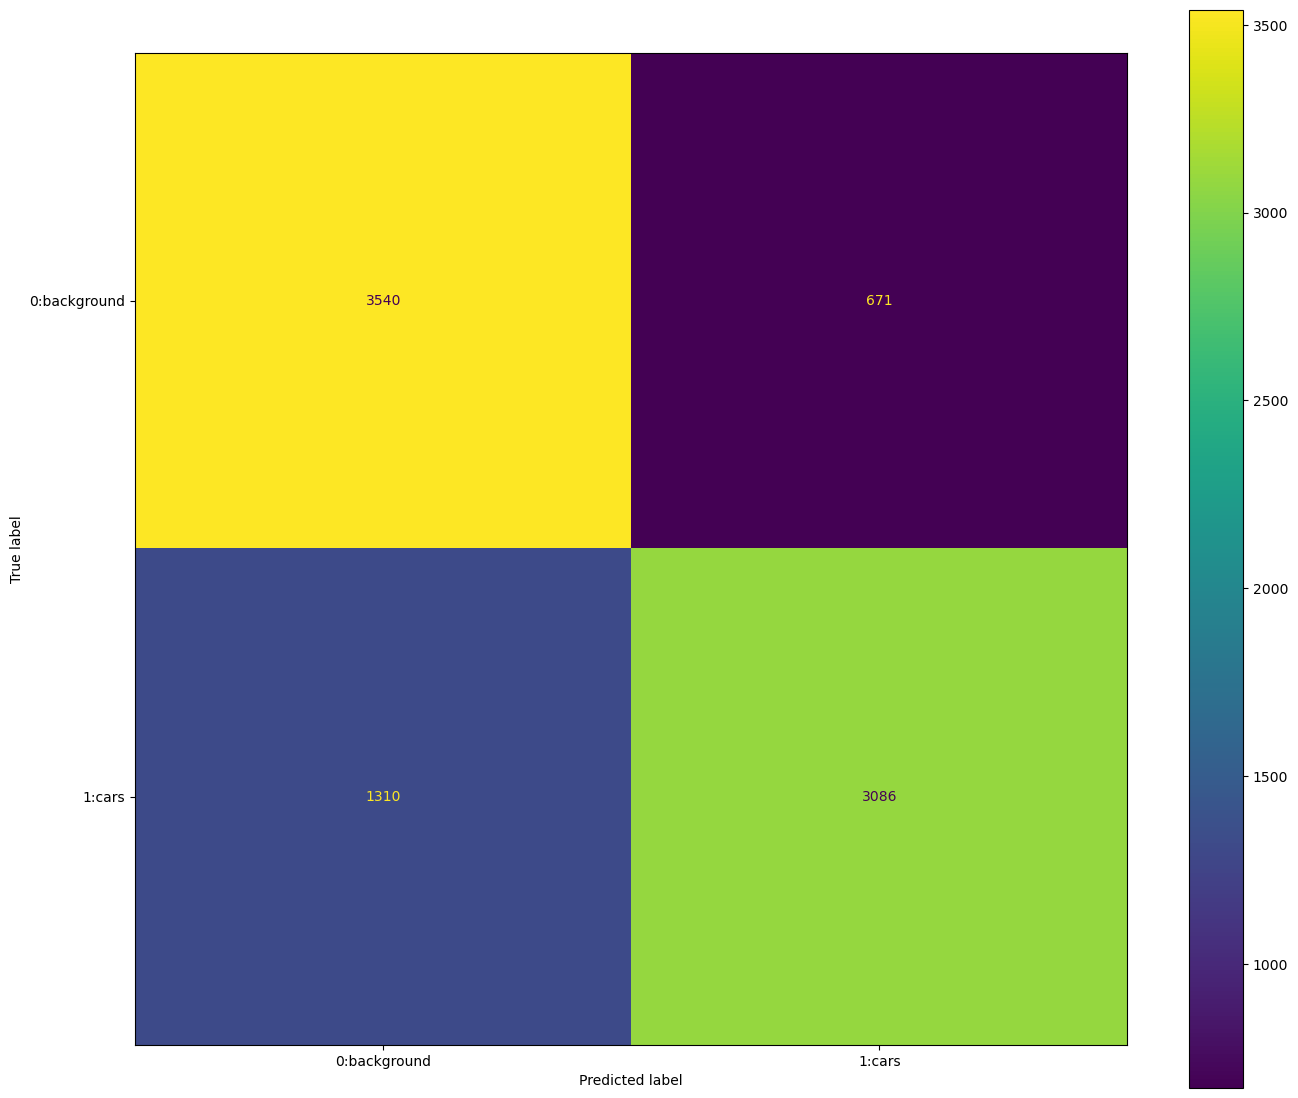

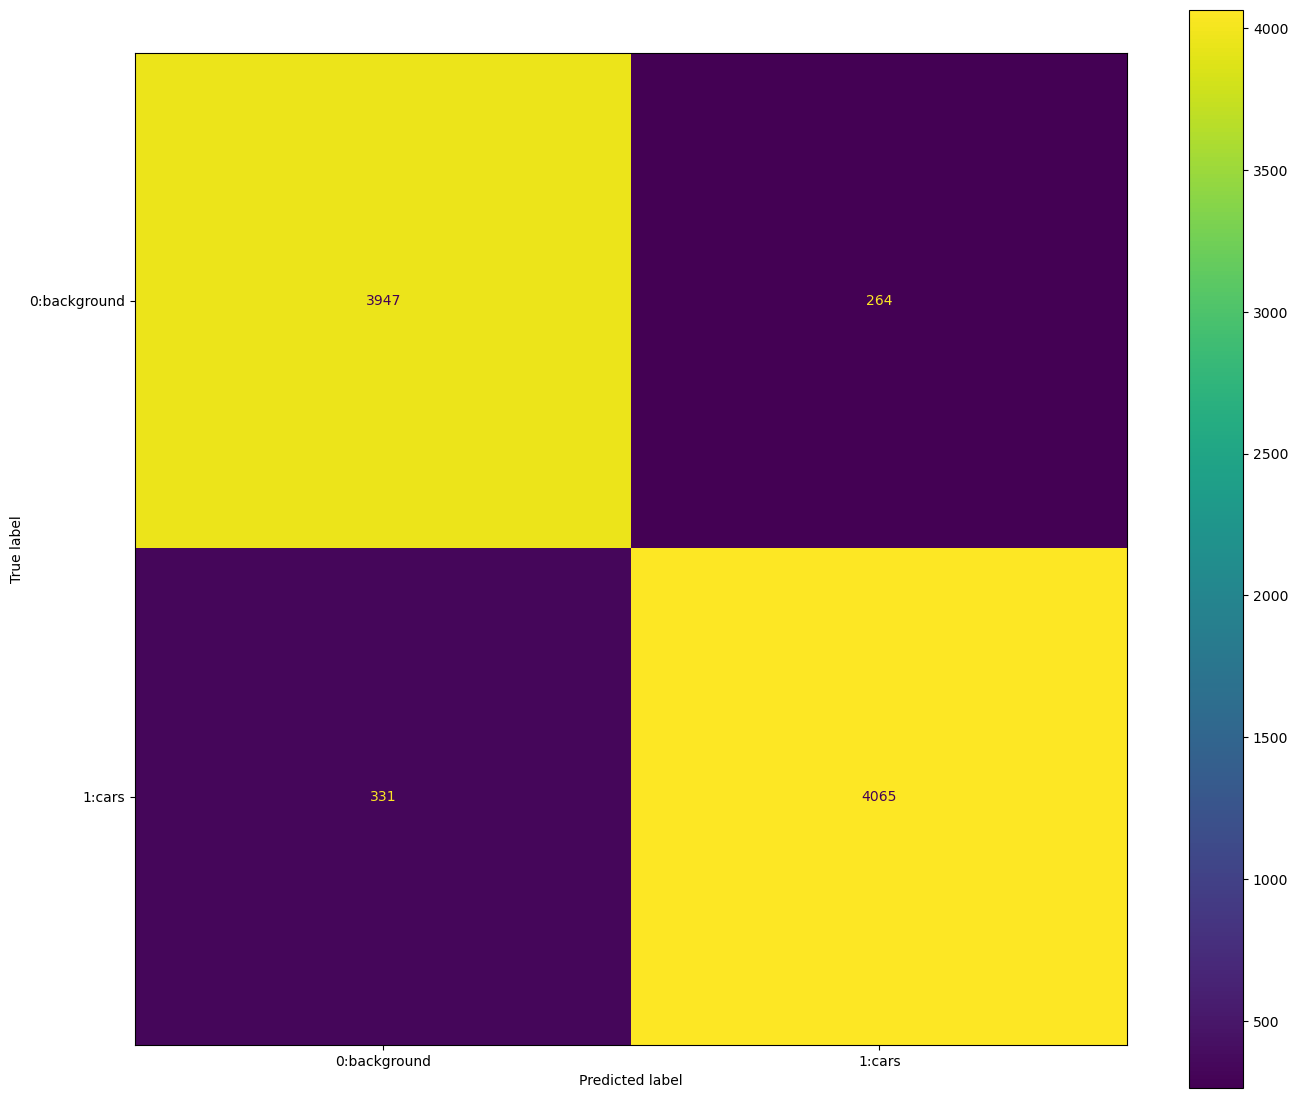

In [83]:
for i,CM_output in enumerate(CM_outputs):
    print(cfgs[i].model)
    disp = ConfusionMatrixDisplay(confusion_matrix=CM_output[0], display_labels = [f'{i}:{c}' for i,c in enumerate(ds.categories)])
    fig, axs = plt.subplots(1, 1, figsize=(16,14))
    disp.plot(ax=axs)
plt.show()

In [18]:
off_zero = confusion_matrix_computed - np.diag(np.diag(confusion_matrix_computed))
gg =  np.unravel_index(np.argsort(off_zero, axis=None), off_zero.shape)
for i in range(1, 20):
    print(f'The {i}th largest off-diagonal element is {off_zero[gg[0][-i], gg[1][-i]]} at ({gg[0][-i]}:{ds.categories[gg[0][-i]]} -> {gg[1][-i]}:{ds.categories[gg[1][-i]]})')

The 1th largest off-diagonal element is 1310 at (1:cars -> 0:background)
The 2th largest off-diagonal element is 671 at (0:background -> 1:cars)
The 3th largest off-diagonal element is 0 at (1:cars -> 1:cars)
The 4th largest off-diagonal element is 0 at (0:background -> 0:background)


IndexError: index -5 is out of bounds for axis 0 with size 4

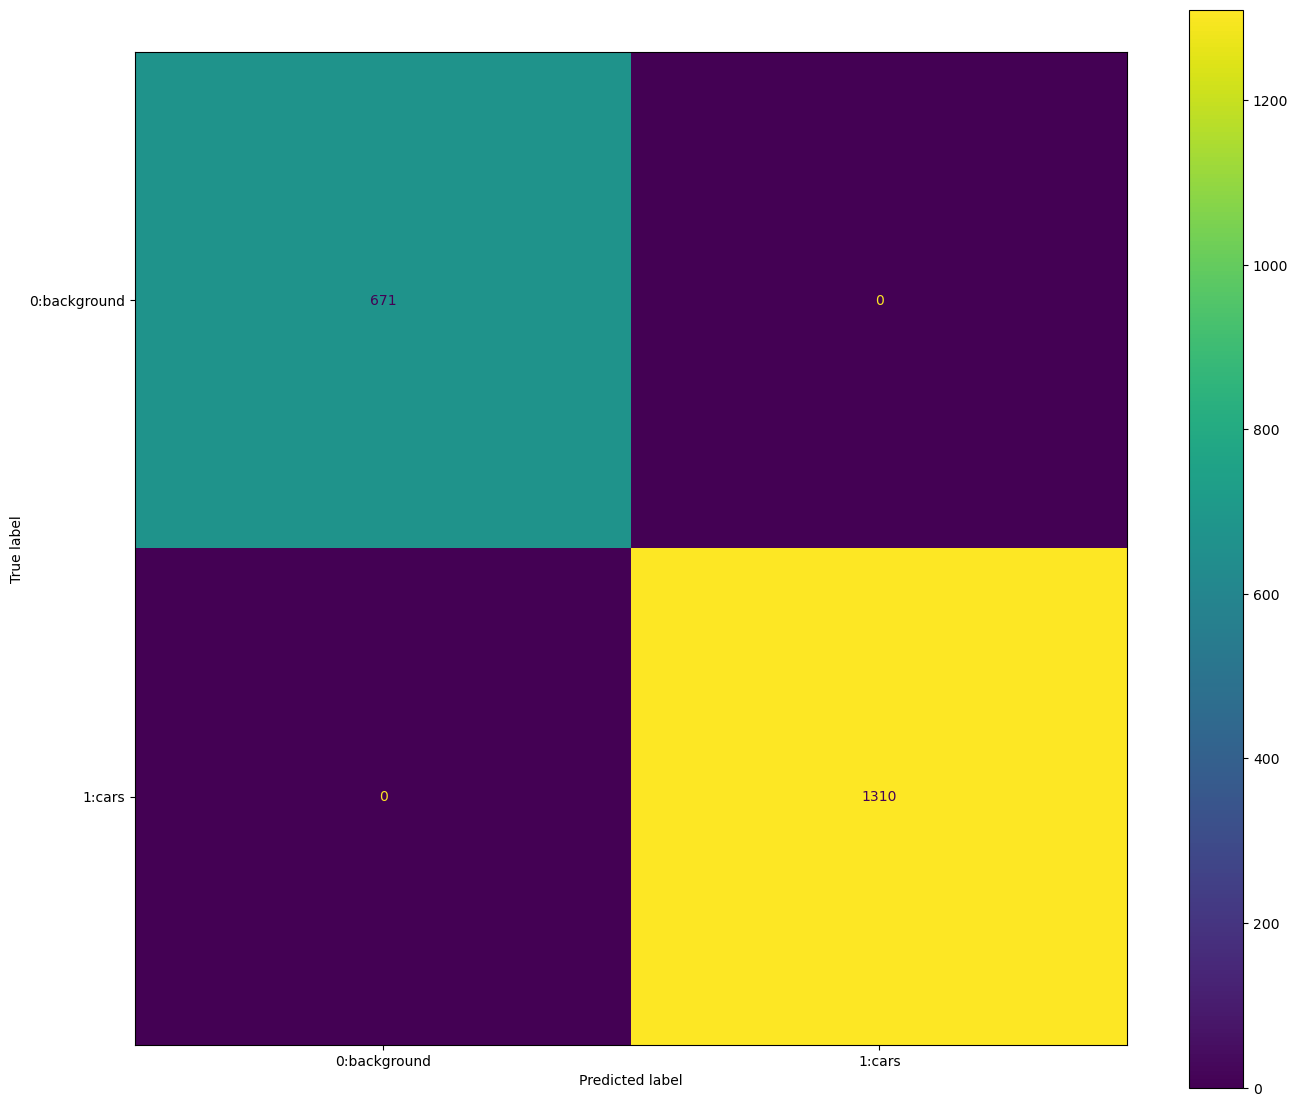

In [19]:
err_mat = np.diag(np.sum(off_zero,axis=1)) #+ np.diag(np.sum(off_zero,axis=0)) 
disp = ConfusionMatrixDisplay(confusion_matrix=err_mat, display_labels = [f'{i}:{c}' for i,c in enumerate(ds.categories)])
fig, axs = plt.subplots(1, 1, figsize=(16,14))
disp.plot(ax=axs)
plt.show()

In [96]:
y_true = CM_outputs[0][1]
files = CM_outputs[0][3]
y_mobilenet = CM_outputs[0][2]
y_resnet = CM_outputs[1][2]

study_list = []
for i in np.where((y_true == 1) & (y_resnet == 1) & (y_mobilenet == 0))[0]:
    study_list.append((i,osp.join(ds[i].label[0],files[i])))
    print(i,ds[i].label[0],files[i])
print(len(study_list))

6 cars obj_004108_td.dat
14 cars obj_003847_td.dat
15 cars obj_001849_td.dat
17 cars obj_003307_td.dat
18 cars obj_004072_td.dat
19 cars obj_004132_td.dat
25 cars obj_000270_td.dat
29 cars obj_002064_td.dat
44 cars obj_003730_td.dat
53 cars obj_002257_td.dat
63 cars obj_002194_td.dat
69 cars obj_002402_td.dat
75 cars obj_002382_td.dat
79 cars obj_000861_td.dat
83 cars obj_002343_td.dat
85 cars obj_002010_td.dat
87 cars obj_001083_td.dat
89 cars obj_003870_td.dat
101 cars obj_003738_td.dat
108 cars obj_004337_td.dat
116 cars obj_000430_td.dat
120 cars obj_000527_td.dat
121 cars obj_002663_td.dat
122 cars obj_002260_td.dat
123 cars obj_003517_td.dat
127 cars obj_000507_td.dat
134 cars obj_002888_td.dat
142 cars obj_000754_td.dat
144 cars obj_000560_td.dat
146 cars obj_004013_td.dat
153 cars obj_003230_td.dat
157 cars obj_001608_td.dat
158 cars obj_002272_td.dat
160 cars obj_002180_td.dat
165 cars obj_003553_td.dat
166 cars obj_002339_td.dat
169 cars obj_001077_td.dat
170 cars obj_000332_

In [89]:
name2ind = {d.file_id: i  for i, d in enumerate(ds)}

In [25]:
count = 0
for n,v in name2ind.items():
    if n.startswith('t_'):
        print(n, v)
        count += 1
        if count == 20:
            break

In [30]:
idx = torch.randint(0, len(ds),(1,))
idx = [6]
# idx = (name2ind['l_0011.mat'],)
correct = 0
total = 0

y1_hat = []
model.eval()

with torch.no_grad():
    for ii in tqdm(range(1000)):
        
        data = ds[idx][0]
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
        data = data.to(device)
        
        out = model(data)
        label = torch.argmax(out, dim=1)
        y1_hat.append(label.cpu().item())
        correct += torch.sum(label == data.y)
        total += data.y.shape[0]
    # loss = runner.loss_fn(y_hat, y)
print(data.file_id)  
print(data.label[0])
print(correct/total)
print([ds.categories[int(c)] for c in np.unique(np.array(y1_hat))])

100%|██████████| 1000/1000 [00:14<00:00, 70.73it/s]

obj_000379_td.dat
background
tensor(1., device='cuda:0')
['background']


In [31]:
ds[6]

Data(x=[5497, 1], pos=[5497, 3], file_id='obj_000379_td.dat', label=[1], y=[1])

In [27]:
np.where(np.array(y1_hat) !=  ds[idx][0].y.clone().detach().cpu().numpy())

(array([], dtype=int64),)

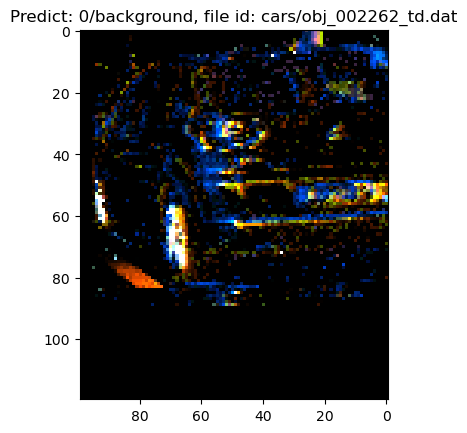

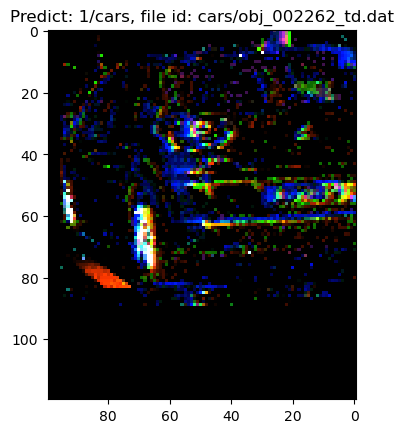

In [98]:
idx = 4160
# idx = name2ind['cars/obj_000623_td.dat']
data = ds[idx]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
data = data.to(device)

for model in models:
    fig, axs = plt.subplots(1, 1)
    model.eval()
    out = model(data)
    vox = model.quantization_layer.forward(data)
    label = torch.argmax(out, dim=1)
    rep = create_image(vox)
    axs.imshow(rep.permute(1,2,0))
    axs.invert_xaxis()
    axs.set_title(f"Predict: {label.item()}/{ds.categories[label.item()]}, file id: {data.label[0]}/{data.file_id}")
    axs.set_aspect('equal', 'box')
plt.show()

In [ ]:

ys = [d.y.clone().detach().item() for d in ds]
ys = np.array(ys)

# count the number of happening of each value in the numpy array
unique, counts = np.unique(ys, return_counts=True)

print(counts)
print(counts.sum())

In [ ]:
n = 1
m = 2
with torch.no_grad():
    for u in unique:
        fig, axs = plt.subplots(n, m, figsize=(m*8,n*6))
        if n == 1:
            axs = axs[None,...]
        if m == 1:
            axs = axs[...,None]
        print(u)

        for i in range(n):
            for j in range(m):
                
                indices = np.where(ys == u)[0]
                idx = np.random.choice(indices)
                
                data = ds[idx]
                
                data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
                data = data.to(device)
                out = model(data)
                vox = model.quantization_layer.forward(data)
                label = torch.argmax(out, dim=1)
                if label != u:
                    print("Wrong label")
                rep = create_image(vox)
                axs[i,j].imshow(rep.permute(1,2,0))
                # axs[i,j].invert_yaxis()
                axs[i,j].set_title(f"Predict: {label.item()}/{ds.categories[label.item()]}, file id: {data.label[0]}/{data.file_id}, idx: {idx}")

        plt.show()


In [ ]:
ds.categories[0]